In [1]:
%env SPECTRAL_CONNECTIVITY_ENABLE_GPU=true

env: SPECTRAL_CONNECTIVITY_ENABLE_GPU=true


In [2]:

import cupy as xp
from cupyx.scipy.fft import ifft
from cupyx.scipy.sparse.linalg import svds
from spectral_connectivity import Multitaper, Connectivity
import lfp_analysis.LFP_recording as LFP_recording
import lfp_analysis.LFP_collection as LFP_collection
import lfp_analysis.preprocessor as preprocessor
import importlib
import pandas as pd
from itertools import combinations
import os
from bidict import bidict
import pickle

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

TRYING GPU!
THIS IS GPU
c:\Users\Padilla-Coreano\.conda\envs\ephy_analysis\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Padilla-Coreano\.conda\envs\ephy_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Padilla-Coreano\Desktop\GITHUB_REPOS\diff_fam_social_memory_ephys\lfp\trodes\read_exported.py:55: SyntaxWarning: invalid escape sequence '\*'
  data_path = data + "\*"
c:\Users\Padilla-Coreano\Desktop\GITHUB_REPOS\diff_fam_social_memory_ephys\lfp\trodes\read_exported.py:57: SyntaxWarning: invalid escape sequence '\*'
  files = [glob.glob(f"{folder}\*merged.rec") for folder in folders]
c:\Users\Padilla-Coreano\Desktop\GITHUB_REPOS\diff_fam_social_memo

In [3]:
df = pd.read_excel(r".\channel_mapping_sme.xlsx")
spike_cols = [col for col in df.columns if 'spike_interface_' in col.lower()]

# Extract brain regions from column names
# Assumes format 'spike_interface_REGION'
brain_regions = [col.split('spike_interface_')[1] for col in spike_cols]

# Create nested dictionary
subject_to_channel_dict = {}

for _, row in df.iterrows():
    subject = row['Subject'].astype(str)
    # Initialize inner dictionary for this subject
    subject_to_channel_dict[subject] = {}
    
    # Populate inner dictionary with brain region: spike value pairs
    for col, region in zip(spike_cols, brain_regions):
        subject_to_channel_dict[subject][region] = int(row[col])
print(subject_to_channel_dict)

{'1.1': {'mPFC': 19, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '1.2': {'mPFC': 26, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '1.3': {'mPFC': 9, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '2.1': {'mPFC': 15, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '2.2': {'mPFC': 7, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '2.3': {'mPFC': 19, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '2.4': {'mPFC': 10, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '3.1': {'mPFC': 25, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '3.2': {'mPFC': 26, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '3.3': {'mPFC': 26, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '4.1': {'mPFC': 25, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}, '4.4': {'mPFC': 25, 'vHPC': 31, 'BLA': 30, 'NAc': 28, 'MD': 29}}


In [4]:
data_path = r"C:\Users\Padilla-Coreano\UFL Dropbox\Caroline De Paula Cunha Almeida\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Cups\data"
behavior_dicts = unpickle_this("cups_behavior_dicts.pkl")
print(behavior_dicts.keys())
recording_to_subject = {}
recording_to_behavior_dict = {}
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('merged.rec'):
            subject = str(int((file.split("_")[0]))/10)
            
            if subject in behavior_dicts.keys():
                recording_to_subject[file] = subject
                behavior_dict = behavior_dicts[subject]
                recording_to_behavior_dict[file] = behavior_dict

file = r"C:\Users\Padilla-Coreano\UFL Dropbox\Caroline De Paula Cunha Almeida\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Cups\21_cups_p4.rec\21_cups_p4_merged.rec"
trodes_directory = r'C:\Users\Padilla-Coreano\Desktop\Trodes_2-5-3_Windows64'
            

dict_keys(['1.1', '1.3', '2.1', '2.2', '2.3', '2.4', '3.1', '3.2', '4.1', '4.4'])


In [5]:
import trodes.read_exported

trodes.read_exported.trodes_extract_single_file(trodes_directory, file, "-time")

In [6]:
collection = LFP_collection.LFPCollection(recording_to_behavior_dict, subject_to_channel_dict, data_path, recording_to_subject, 4, trodes_directory)
#roughly 13 min for 9 recordings

Processing 11_cups_p4_merged.rec
Found first timestamp


c:\Users\Padilla-Coreano\Desktop\GITHUB_REPOS\diff_fam_social_memory_ephys\lfp\trodes\read_exported.py:167: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Processing 13_cups_p4_merged.rec
Found first timestamp
Processing 21_cups_p4_merged.rec
Found first timestamp
Processing 22_cups_p4_merged.rec
Found first timestamp
Processing 23_cups_p4_merged.rec
Found first timestamp
Processing 24_cups_p4_merged.rec
Found first timestamp
Processing 31_cups_p4_merged.rec
Found first timestamp
Processing 32_cups_p4_merged.rec
Found first timestamp
Processing 41_cups_p4_merged.rec
Found first timestamp
Processing 44_cups_p4_merged.rec
Found first timestamp


In [7]:
collection.process()

  0%|          | 0/10 [00:00<?, ?it/s]

processing 11_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 5101 of 5189 converged
Maximum iterations reached. 5186 of 5189 converged
Maximum iterations reached. 5188 of 5189 converged
Maximum iterations reached. 5187 of 5189 converged
Maximum iterations reached. 5177 of 5189 converged
Maximum iterations reached. 5187 of 5189 converged
Maximum iterations reached. 5187 of 5189 converged
Maximum iterations reached. 5172 of 5189 converged
Maximum iterations reached. 5186 of 5189 converged
 10%|█         | 1/10 [07:00<1:03:05, 420.67s/it]

Granger's causality calculated
processing 13_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 5072 of 5162 converged
Maximum iterations reached. 5152 of 5162 converged
Maximum iterations reached. 5161 of 5162 converged
Maximum iterations reached. 5086 of 5162 converged
Maximum iterations reached. 5141 of 5162 converged
Maximum iterations reached. 5161 of 5162 converged
Maximum iterations reached. 5152 of 5162 converged
Maximum iterations reached. 5160 of 5162 converged
 20%|██        | 2/10 [13:48<55:04, 413.04s/it]  

Granger's causality calculated
processing 21_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 5006 of 5040 converged
Maximum iterations reached. 5039 of 5040 converged
Maximum iterations reached. 5039 of 5040 converged
Maximum iterations reached. 5038 of 5040 converged
Maximum iterations reached. 4987 of 5040 converged
Maximum iterations reached. 4986 of 5040 converged
Maximum iterations reached. 5038 of 5040 converged
Maximum iterations reached. 4957 of 5040 converged
Maximum iterations reached. 5039 of 5040 converged
Maximum iterations reached. 5038 of 5040 converged
 30%|███       | 3/10 [29:18<1:15:43, 649.03s/it]

Granger's causality calculated
processing 22_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 4805 of 5207 converged
Maximum iterations reached. 5184 of 5207 converged
Maximum iterations reached. 5161 of 5207 converged
Maximum iterations reached. 5206 of 5207 converged
Maximum iterations reached. 5129 of 5207 converged
Maximum iterations reached. 5018 of 5207 converged
Maximum iterations reached. 5123 of 5207 converged
 40%|████      | 4/10 [36:15<55:45, 557.61s/it]  

Granger's causality calculated
processing 23_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 4966 of 5040 converged
Maximum iterations reached. 5038 of 5040 converged
Maximum iterations reached. 4992 of 5040 converged
Maximum iterations reached. 5012 of 5040 converged
Maximum iterations reached. 5038 of 5040 converged
Maximum iterations reached. 5016 of 5040 converged
Maximum iterations reached. 5038 of 5040 converged
 50%|█████     | 5/10 [53:15<1:00:22, 724.42s/it]

Granger's causality calculated
processing 24_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 4914 of 4920 converged
Maximum iterations reached. 4919 of 4920 converged
Maximum iterations reached. 4919 of 4920 converged
Maximum iterations reached. 4902 of 4920 converged
Maximum iterations reached. 4908 of 4920 converged
Maximum iterations reached. 4913 of 4920 converged
Maximum iterations reached. 4918 of 4920 converged
 60%|██████    | 6/10 [1:17:28<1:04:48, 972.14s/it]

Granger's causality calculated
processing 31_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 5011 of 5058 converged
Maximum iterations reached. 5055 of 5058 converged
Maximum iterations reached. 5055 of 5058 converged
Maximum iterations reached. 5018 of 5058 converged
Maximum iterations reached. 5042 of 5058 converged
Maximum iterations reached. 5052 of 5058 converged
Maximum iterations reached. 5057 of 5058 converged
 70%|███████   | 7/10 [1:40:37<55:24, 1108.15s/it] 

Granger's causality calculated
processing 32_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 4987 of 5063 converged
Maximum iterations reached. 5062 of 5063 converged
Maximum iterations reached. 5062 of 5063 converged
Maximum iterations reached. 5058 of 5063 converged
Maximum iterations reached. 5056 of 5063 converged
Maximum iterations reached. 5058 of 5063 converged
Maximum iterations reached. 5059 of 5063 converged
Maximum iterations reached. 5058 of 5063 converged
Maximum iterations reached. 5060 of 5063 converged
 80%|████████  | 8/10 [2:06:04<41:23, 1241.67s/it]

Granger's causality calculated
processing 41_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 5002 of 5060 converged
Maximum iterations reached. 5049 of 5060 converged
Maximum iterations reached. 5057 of 5060 converged
Maximum iterations reached. 5057 of 5060 converged
Maximum iterations reached. 4995 of 5060 converged
Maximum iterations reached. 5011 of 5060 converged
Maximum iterations reached. 5010 of 5060 converged
Maximum iterations reached. 5022 of 5060 converged
Maximum iterations reached. 5012 of 5060 converged
Maximum iterations reached. 4929 of 5060 converged
 90%|█████████ | 9/10 [2:35:36<23:27, 1407.57s/it]

Granger's causality calculated
processing 44_cups_p4_merged.rec
RMS Traces calculated
Power Calculated
Coherence calcualatd


Maximum iterations reached. 4786 of 5059 converged
Maximum iterations reached. 5004 of 5059 converged
Maximum iterations reached. 4974 of 5059 converged
Maximum iterations reached. 5046 of 5059 converged
Maximum iterations reached. 4916 of 5059 converged
Maximum iterations reached. 4892 of 5059 converged
Maximum iterations reached. 5047 of 5059 converged
Maximum iterations reached. 4857 of 5059 converged
Maximum iterations reached. 5050 of 5059 converged
Maximum iterations reached. 5050 of 5059 converged
100%|██████████| 10/10 [3:04:57<00:00, 1109.77s/it]

Granger's causality calculated


In [8]:
pickle_this(collection, r"C:\Users\Padilla-Coreano\UFL Dropbox\Caroline De Paula Cunha Almeida\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\processed_lfp_pickles\cups_p4_processed_lfp.pkl")

In [12]:
from spectral_connectivity import Multitaper, Connectivity
import lfp_analysis.Analysis as analysis
import matplotlib.pyplot as plt
importlib.reload(LFP_recording)
importlib.reload(preprocessor)
importlib.reload(analysis)



<module 'lfp_analysis.Analysis' from 'c:\\Users\\Padilla-Coreano\\Desktop\\GITHUB_REPOS\\diff_fam_social_memory_ephys\\lfp\\lfp_analysis\\Analysis.py'>

All set to analyze


c:\Users\Padilla-Coreano\Desktop\GITHUB_REPOS\diff_fam_social_memory_ephys\lfp\lfp_analysis\Analysis.py:177: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis=0)
c:\Users\Padilla-Coreano\Desktop\GITHUB_REPOS\diff_fam_social_memory_ephys\lfp\lfp_analysis\Analysis.py:235: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(averages, axis=0)


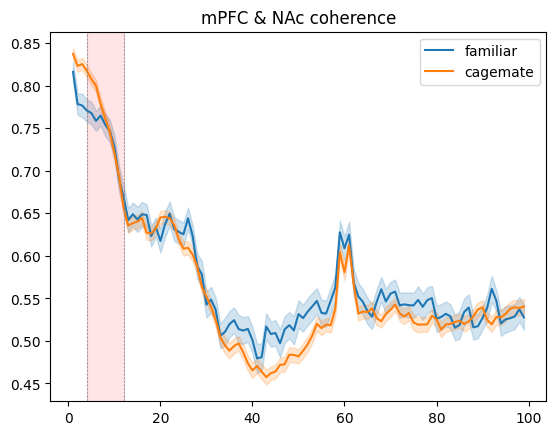

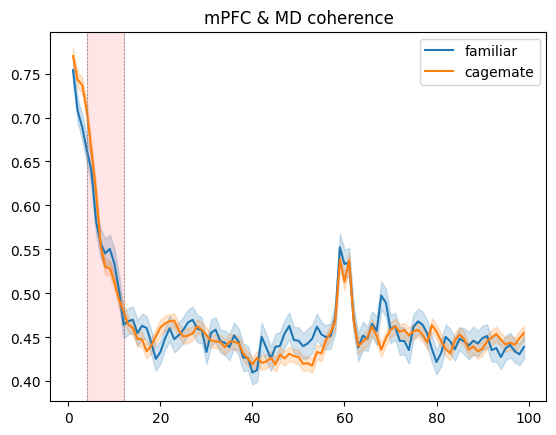

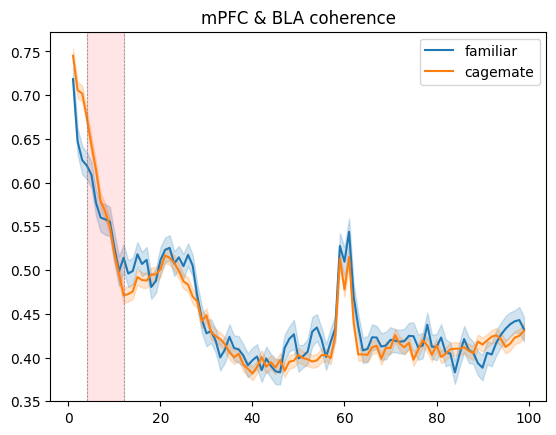

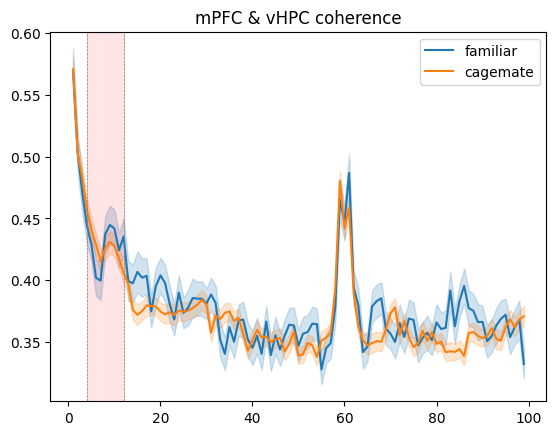

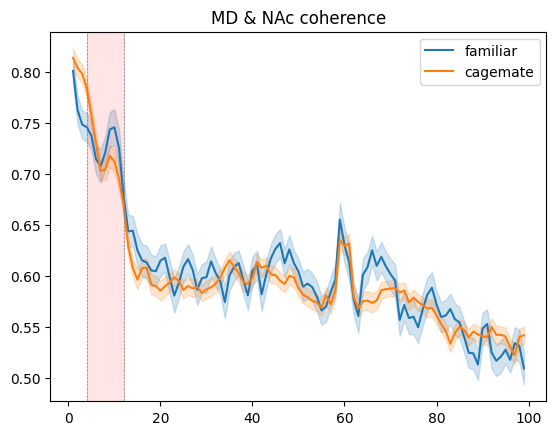

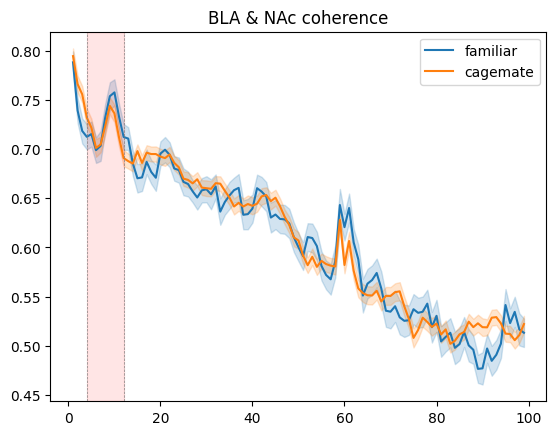

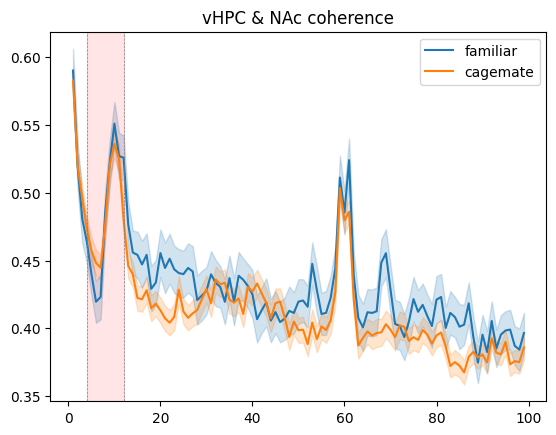

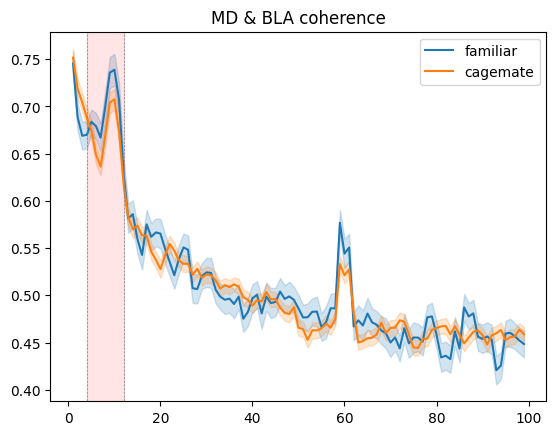

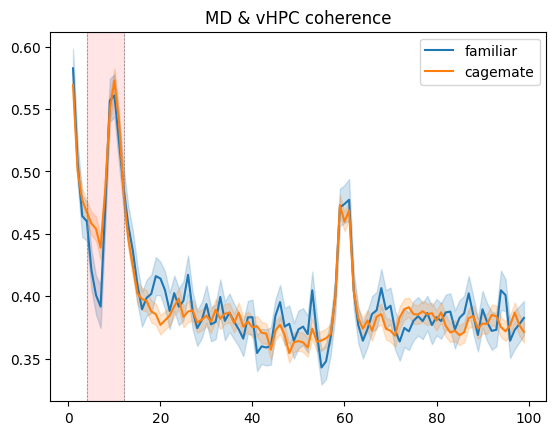

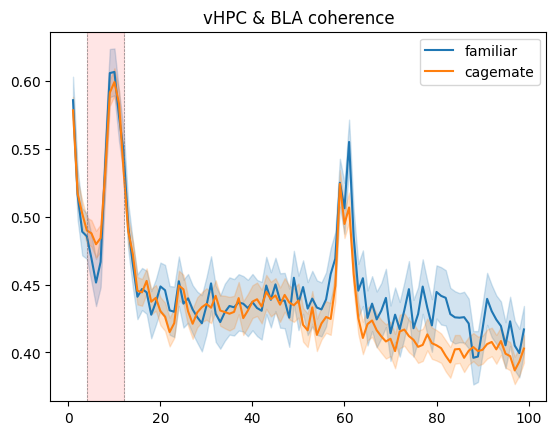

In [19]:
test = analysis.LFPAnalysis(collection.lfp_recordings)
event_averages = test.average_events(events = ['familiar', 'cagemate'], mode = 'coherence', 
                baseline = None, plot = True)



In [20]:
event_averages

{'familiar': [array([[[       nan, 0.3645192 , 0.58551459, 0.45851905, 0.39948445],
          [0.3645192 ,        nan, 0.4019409 , 0.8271314 , 0.85729377],
          [0.58551459, 0.4019409 ,        nan, 0.49580358, 0.64073421],
          [0.45851905, 0.8271314 , 0.49580358,        nan, 0.84883851],
          [0.39948445, 0.85729377, 0.64073421, 0.84883851,        nan]],
  
         [[       nan, 0.80094158, 0.83069933, 0.79815184, 0.42434548],
          [0.80094158,        nan, 0.77798508, 0.84750408, 0.61899761],
          [0.83069933, 0.77798508,        nan, 0.73646572, 0.40805258],
          [0.79815184, 0.84750408, 0.73646572,        nan, 0.71156279],
          [0.42434548, 0.61899761, 0.40805258, 0.71156279,        nan]],
  
         [[       nan, 0.92200067, 0.53572056, 0.87075784, 0.82604957],
          [0.92200067,        nan, 0.45303425, 0.95309446, 0.86838016],
          [0.53572056, 0.45303425,        nan, 0.39306274, 0.54166855],
          [0.87075784, 0.95309446, 0.3930627

C:\Users\Padilla-Coreano\AppData\Local\Temp\ipykernel_21296\1328686797.py:16: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(averages, axis=0)


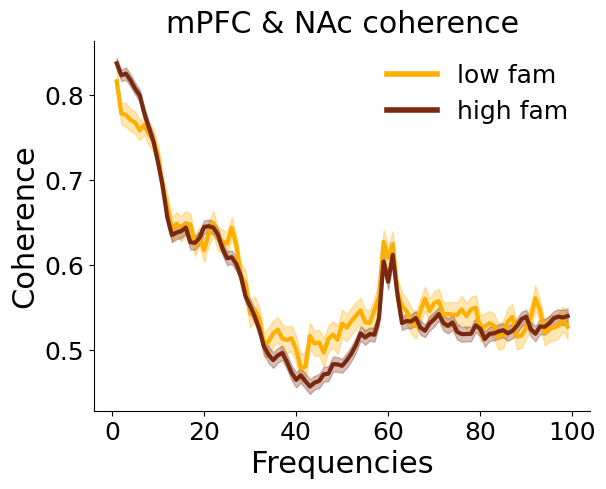

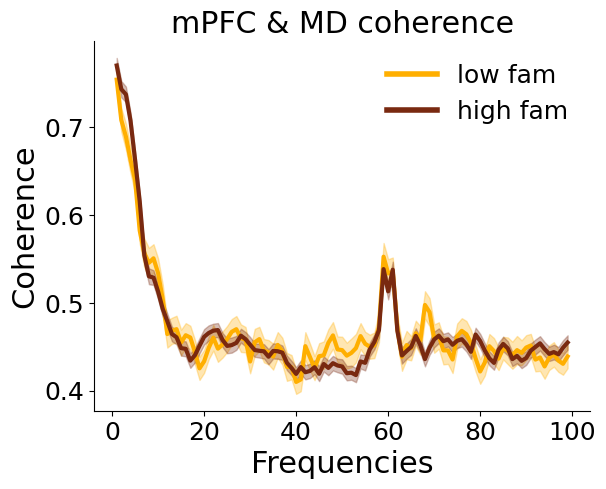

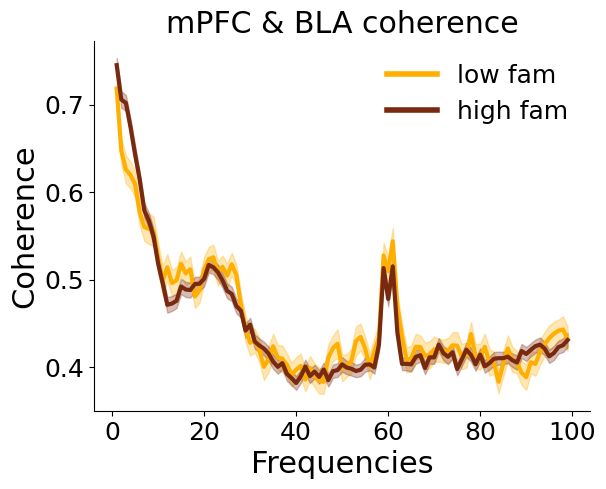

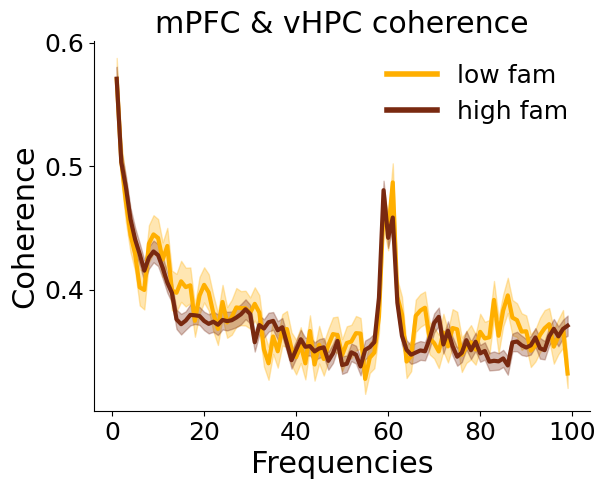

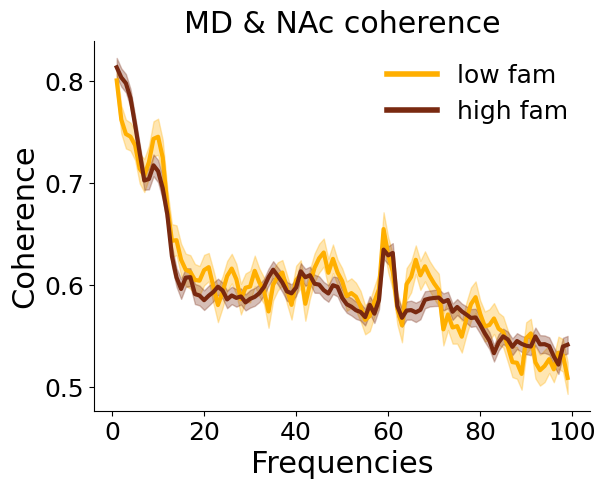

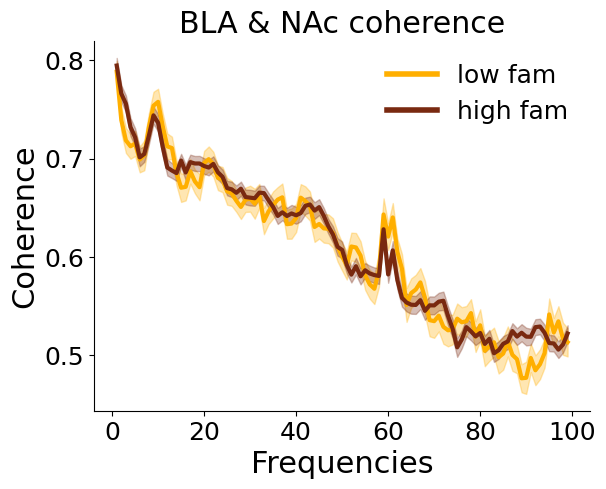

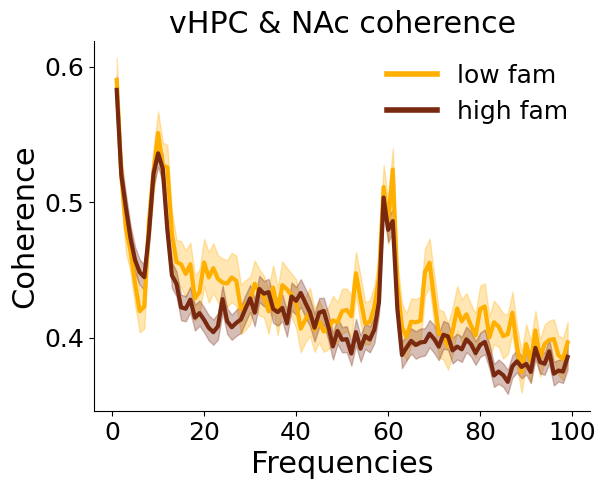

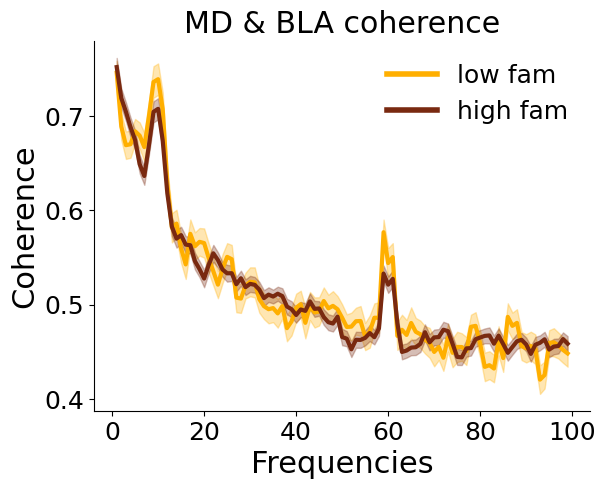

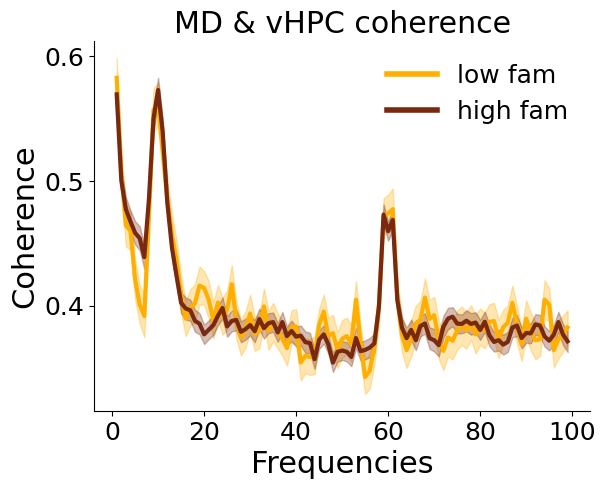

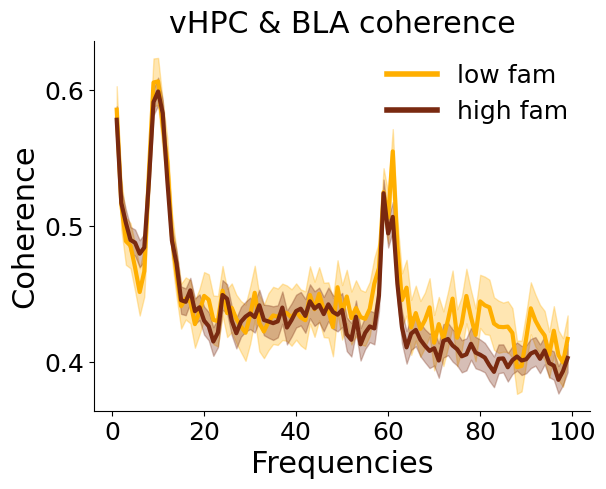

In [ ]:
from scipy import stats
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D  # Import for custom legend handles
event_averages = {
    "low fam" if key == "familiar" else "high fam" if key == "cagemate" else key: value for key, value in event_averages.items()}
low_fam_color = hex_2_rgb('#FFAF00')
high_fam_color = hex_2_rgb('#792910')
plt.rcParams.update({'font.size': 18})
for i in range(len(regions)):
    for event, averages in event_averages.items():
        first_region, second_region = list(regions[i])
        first_region_name = test.brain_region_dict.inverse[first_region]
        second_region_name = test.brain_region_dict.inverse[second_region]
        averages = event_averages[event]
        event_average = np.nanmean(averages, axis=0)
        event_sem = stats.sem(averages, axis=0, nan_policy="omit")
        y_sem = event_sem[1:100, first_region, second_region]
        y = event_average[1:100, first_region, second_region]
        x = test.coherence_frequencies[1:100]

        # Assign colors based on the event label
        if event == "low fam":
            color = low_fam_color
        elif event == "high fam":
            color = high_fam_color
        else:
            color = None  # Default color

        (line,) = plt.plot(x, y, label=event, color=color, linewidth = 3)
        plt.fill_between(x, y - y_sem, y + y_sem, color=color, alpha=0.3)

    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax)

    # Set y-axis ticks at 0.1 intervals
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
    legend_handles = [
        Line2D([0], [0], color=low_fam_color, lw=4, label="low fam"),  # Line width = 4
        Line2D([0], [0], color=high_fam_color, lw=4, label="high fam")  # Line width = 4
    ]
    plt.legend(handles=legend_handles, frameon=False)
    # Remove the top and right frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Customize legend to remove frame
   # plt.legend(frameon=False)

    plt.ylabel('Coherence', fontsize = 22)
    plt.xlabel('Frequencies (Hz)', fontsize = 22)
    plt.title(f"{first_region_name} & {second_region_name} coherence")
    plt.show()


In [16]:
event_averages = []
event_sems = []
recordings = []
from matplotlib.patches import Patch 
import numpy as np
from scipy import stats
# Define the events
events = ['cagemate', 'novel', 'recall']
coherence_pair = ['mPFC','vHPC']
index1, index2 = list(test.coherence_pairs_dict[frozenset({coherence_pair})])
freq_range = [12, 30]

# Loop through each recording and each event
for recording in collection.lfp_recordings:
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)
    for event in events:
        event_average = test.__get_event_averages__(recording,
                                                             event=event,
                                                             mode='coherence',
                                                             event_len=None,
                                                             pre_window=0,
                                                             post_window=0)
        event_array = np.array(event_average)
        event_average = np.nanmean(event_array[:, freq_range[0]:freq_range[1], index1, index2], axis=1)
        event_mean = np.nanmean(np.array(event_average[:]), axis=0)
        event_sem = stats.sem(np.array(event_average), axis=0, nan_policy='omit')
        event_averages.append(event_mean)
        event_sems.append(event_sem)

# Define the number of bars and their positions
num_recordings = len(test.collection)
num_events = len(events)
bar_width = 0.2
x = np.arange(num_recordings)

# Define colors for each event
colors = ['skyblue', 'lightgreen', 'lightcoral']
color_map = {events[i]: colors[i] for i in range(num_events)}

# Create the bar plot
plt.figure(figsize=(10, 8))

# Plot each bar with appropriate color and error bars
for i, recording in enumerate(recordings):
    for j, event in enumerate(events):
        idx = i * num_events + j
        plt.barh(x[i] + j * bar_width, event_averages[idx], xerr=event_sems[idx], 
                 capsize=5, color=color_map[event], edgecolor='black', height=bar_width,
                 label=event if i == 0 else '')

# Add labels and title
plt.ylabel('Recordings', fontsize=14)
plt.xlabel('Value', fontsize=14)
plt.title(f'Freq {freq_range} {coherence_pair} coherence', fontsize=16)

# Set custom y-ticks
ytick_positions = x + bar_width
plt.yticks(ytick_positions, recordings)

# Add a legend
handles = [Patch(color=color, label=event) for event, color in color_map.items()]
plt.legend(handles=handles, fontsize=12)

# Customize the plot (optional)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

TypeError: unhashable type: 'list'

In [105]:
rec_tester= collection.lfp_recordings[0]
print(rec_tester.coherence.shape)
len(rec_tester.behavior_dict['cagemate'])
len(rec_tester.behavior_dict['novel'])


(5189, 500, 5, 5)


18

woo
woo
woo
woo
woo
woo
woo
woo
woo


In [49]:
len(event_averages['familiar'])

0

In [59]:
trodes_directory

'C:\\Users\\megha\\Downloads\\Trodes_2-5-2_Windows64\\Trodes_2-5-2_Windows64'

In [65]:
import lfp_analysis.Analysis as analysis
import lfp_analysis.connectivity_wrapper as wrapper
importlib.reload(analysis)
importlib.reload(preprocessor)
importlib.reload(LFP_recording)
importlib.reload(wrapper)

<module 'lfp_analysis.connectivity_wrapper' from 'c:\\Users\\megha\\Documents\\GitHub\\diff_fam_social_memory_ephys\\lfp\\lfp_analysis\\connectivity_wrapper.py'>

In [60]:
merged_rec_path = r"D:\cups\data\11_cups_p4.rec\11_cups_p4_merged.rec"
rec_test = LFP_recording.LFPRecording(subject = '1.1', 
                                      behavior_dict=behavior_dicts['1.1'], 
                                      channel_dict=subject_to_channel_dict['1.1'], 
                                      merged_rec_path=merged_rec_path,
                                      trodes_directory=trodes_directory)


Processing 11_cups_p4_merged.rec


c:\Users\megha\Documents\GitHub\diff_fam_social_memory_ephys\lfp\trodes\read_exported.py:168: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Found first timestamp


In [66]:
rec_test.process(threshold = 4)

processing 11_cups_p4_merged.rec
RMS Traces calculated
sampling freq 20000
half bandwidth 2
duration 1
step 0.5
sampling freq 20000
half bandwidth 2
duration 1
step 0.5
Power Calculated
sampling freq 20000
half bandwidth 2
duration 1
step 0.5
Coherence calcualatd


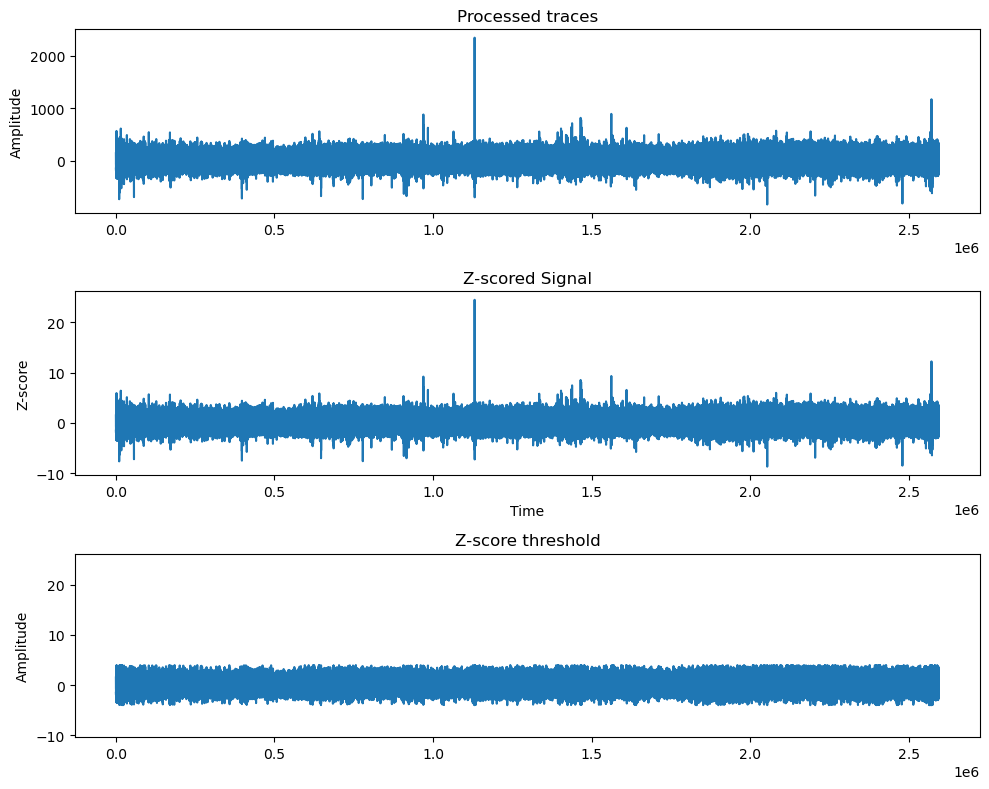

In [ ]:
I_HAVE_PLOTTED_AND_THIS_LOOKS_GOOD = 4
rec_test.plot_to_find_threshold(threshold = I_HAVE_PLOTTED_AND_THIS_LOOKS_GOOD)

In [ ]:
rec_test.process(I_HAVE_PLOTTED_AND_THIS_LOOKS_GOOD)

(10000, 5)


Text(0, 0.5, 'Power')

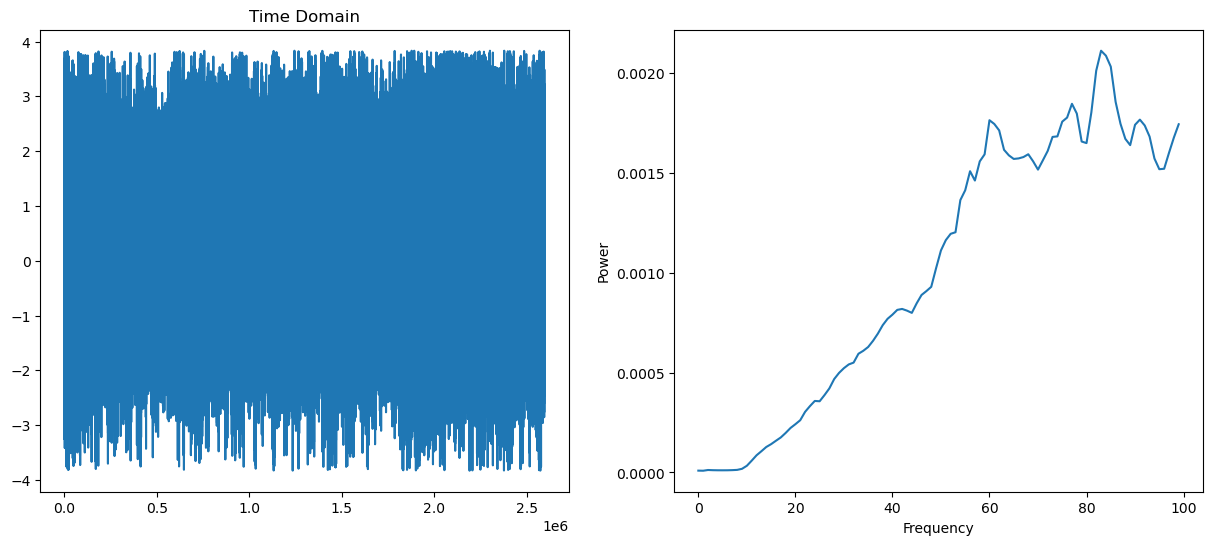

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(rec_test.rms_traces[0].T)
axes[0].set_title("Time Domain")
#connectivity.power.() = [timebins, frequencies, signal]
average_power = np.mean(rec_test.power, axis = 0)
print(average_power.shape)
axes[1].plot(rec_test.frequencies[0:100], average_power[0:100, 0])
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Power")

In [ ]:
print(rec_test.frequencies[0:5])

[0. 1. 2. 3. 4.]


(10000, 5)


Text(0, 0.5, 'Power')

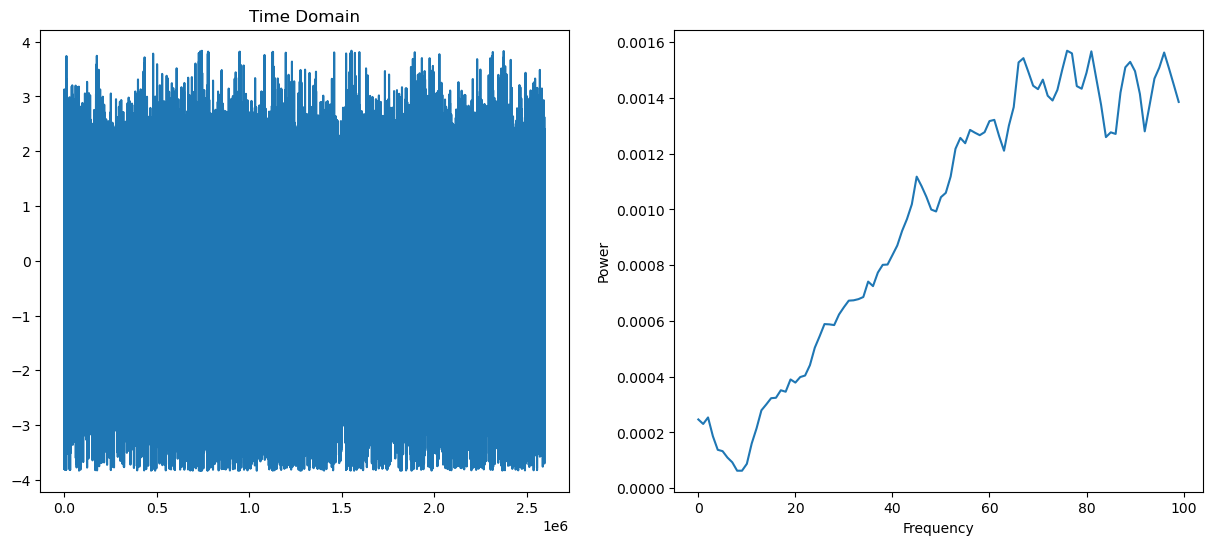

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(rec_test.rms_traces[4].T)
axes[0].set_title("Time Domain")
#connectivity.power.() = [timebins, frequencies, signal]
average_power = np.mean(rec_test.power, axis = 0)
print(average_power.shape)
axes[1].plot(rec_test.frequencies[0:100], average_power[0:100, 4])
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Power")